In [1]:
import time
import os
import re
import gc
import random
from datetime import datetime
from collections import Counter
import numpy as np
from numpy.linalg import solve
from numpy.linalg import linalg
%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [2]:
try:
    input = raw_input
except NameError:
    raw_input = input

df, priorities, districts, columnHeaders = [], [], [], []
weekdays = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
daysInMonth = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
randomSampleSize = 50

In [3]:

def readFile(fileName):
    global priorities
    global districts
    global columnHeaders
    X = []
    headers = True
    count = 0
    with open(fileName, "r") as f:
        for line in f:
            line = line.replace("\n","").split(",")
            if headers == True:
                if count == 0:
                    priorities = line
                elif count == 1:
                    districts = line
                else:
                    columnHeaders = line
                    headers = False
                count += 1
            else:
                line = [ float(i) for i in line ]
                X.append(line)
    return X

def dayOfYear(callDate):
    daysInMonth = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    year, month, day = int(callDate[6:]), int(callDate[:2]), int(callDate[3:5])
    returnValue = day + sum(daysInMonth[0:month])
    returnValue += (1 if year % 4 == 0 and month > 2 else 0)
    if year % 4 == 0 and month > 2:
        returnValue += 1
    del year; del month; del day
    return returnValue

def getError(x, y, coefficients, polyfit = False):
    # get the computer y value with the given coefficients
    #y_computed = [ sum([ (i**j)*coefficients[j] for j in range(len(coefficients))]) for i in x ]
    if polyfit == False:
        y_computed = [ sum(i[j]*coefficients[j+1] for j in range(len(i)))+coefficients[0] for i in x]
    else:
        y_computed = [ sum((i[j]**(j+1))*coefficients[j+1] for j in range(len(i)))+coefficients[0] for i in x]
    #print(y_computed)
    # absolute value of actual value - computer value
    absError = [ abs(y[i] - y_computed[i]) for i in range(len(y)) ]
    maxError = max(absError)
    avgError = sum(absError) / len(absError)
    #  sqrt(sum_over_set(absolute_error^2)/number_in_set)
    rmsError = (sum(map(lambda a: a**2, absError))/len(absError))**(1/2.0)
    del y_computed
    return maxError, avgError, rmsError

def getLinearFit(x, y, constantTerm = True):
    n = len(x[0])
    if constantTerm == True:
        n += 1
    A = [ [0.0 for i in range(n) ] for j in range(n) ]
    Y = [ 0.0 for i in range(n) ]
    for i in range(n):
        if constantTerm == True:
            Y[i] = sum(map(lambda a,b: a[i - 1]*b if i > 0 else b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: (a[i - 1] if i > 0 else 1)*(a[j - 1] if j > 0 else 1), x))
        else:
            Y[i] = sum(map(lambda a,b: a[i]*b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: a[i]*a[j], x))
    #return solve(A, Y)
    return linalg.lstsq(A, Y)

def getPolyFit(x, y, constantTerm = True):
    n = len(x[0])
    if constantTerm == True:
        n += 1
    A = [ [0.0 for i in range(n) ] for j in range(n) ]
    Y = [ 0.0 for i in range(n) ]
    for i in range(n):
        if constantTerm == True:
            Y[i] = sum(map(lambda a,b: (a[i - 1]**i)*b if i > 0 else b, x, y))
            #Y[i] = sum(map(lambda a,b: (list(a)**i)*b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: (a[i - 1]**i if i > 0 else 1)*(a[j - 1]**j if j > 0 else 1), x))
                #A[i][j] = sum(map(lambda a: (list(a)**i)*(list(a)**j), x))
        else:
            Y[i] = sum(map(lambda a,b: (a[i]**i)*b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: (a[i]**i)*(a[j]**i), x))
    #return solve(A, Y)
    return linalg.lstsq(A, Y)

In [4]:
print("Importing the data file as a list...")
df = readFile("./Cleaned_DataFile.csv")
print("Total entries: " + str(len(df)))

Importing the data file as a list...
Total entries: 2011144


In [9]:
randomSampleSize = 100

These section was used for generating graphs and results for the report

In [5]:
subset = []
subset = tuple(tuple(j for j in i) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 1.904963668191208


In [6]:
coef1  = getLinearFit(uniques, yValues)[0]
errors1 = getError(uniques, yValues, coef1)
print("Polynomial coefficients:")
print(coef1)
print("Max Error, Avg Error, RMS Error")
print(errors1[:3])

Polynomial coefficients:
[  3.00850325e+00  -3.87358808e-02  -1.24720548e-03  -9.69099977e-04
   1.26707155e-03   8.47781326e-05   4.72800019e-06  -2.18945604e-05
  -6.99778249e-04  -1.62665134e-04  -1.12645367e-03  -5.13111591e-04]
Max Error, Avg Error, RMS Error
(9.9897447494080698, 0.020343775025452499, 0.10806050876530862)


In [7]:
coef2 = getPolyFit(uniques, yValues)[0]
errors2 = getError(uniques, yValues, coef2, True)
print("Polynomial coefficients:")
print(coef2)
print("Max Error, Avg Error, RMS Error")
print(errors2[:3])

Polynomial coefficients:
[  2.01924605e-33  -1.52588021e-28   8.87468518e-31   1.65026041e-23
   2.18281756e-23   1.97564167e-27   1.91396501e-23   1.17646227e-28
   8.94389244e-29  -9.77261821e-23   4.58795422e-17  -1.13409259e-21]
Max Error, Avg Error, RMS Error
(9.9921656155201468, 0.056574477977471178, 0.22291272362858769)


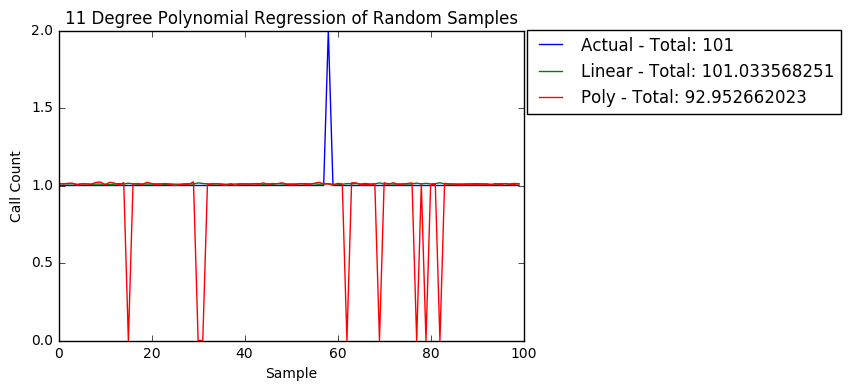

In [10]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef1
traintest2 = coef2
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("11 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [11]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 1)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 2.3561730099677334


In [12]:
coef3 = getLinearFit(uniques, yValues)[0]
errors3 = getError(uniques, yValues, coef3)
print("Polynomial coefficients:")
print(coef3)
print("Max Error, Avg Error, RMS Error")
print(errors3[:3])

Polynomial coefficients:
[  2.24122514e+00  -3.52253311e-02  -1.13367569e-03  -5.90177461e-04
   1.15301839e-03   1.21517375e-04   5.52365330e-06  -3.88164901e-05
  -9.88236120e-04  -1.63110724e-04  -7.96792166e-05]
Max Error, Avg Error, RMS Error
(9.9872881097237354, 0.024118570986317766, 0.11795977693952614)


In [13]:
coef4 = getPolyFit(uniques, yValues)[0]
errors4 = getError(uniques, yValues, coef4, True)
print("Polynomial coefficients:")
print(coef4)
print("Max Error, Avg Error, RMS Error")
print(errors4[:3])

Polynomial coefficients:
[  1.51624696e-20   5.89248347e-20   4.67035880e-18   1.24118762e-10
  -3.34298581e-14   2.30031270e-14   1.59515734e-14   7.50096636e-16
   2.02433509e-17  -1.46789637e-13  -4.63860826e-19]
Max Error, Avg Error, RMS Error
(9.9884294498960688, 0.024121861336073289, 0.11796891981938094)


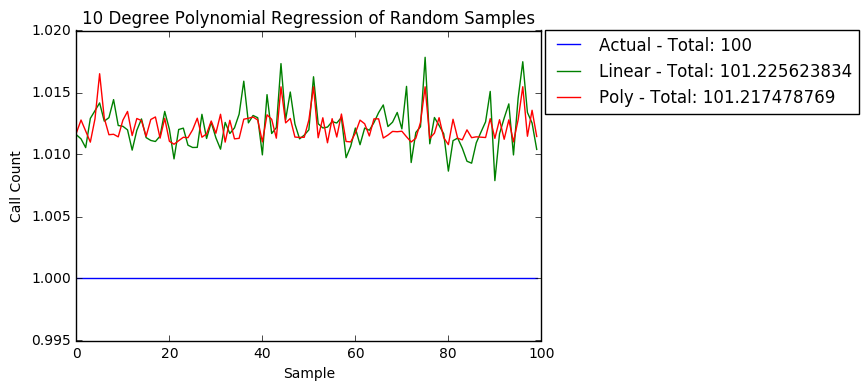

In [14]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef3
traintest2 = coef4
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("10 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [15]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 2)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 2.195147620565649


In [16]:
coef5 = getLinearFit(uniques, yValues)[0]
errors5 = getError(uniques, yValues, coef5)
print("Polynomial coefficients:")
print(coef5)
print("Max Error, Avg Error, RMS Error")
print(errors5[:3])

Polynomial coefficients:
[ -2.44218794e+00  -4.79108449e-03  -8.59590137e-05   1.72747329e-03
   1.64967425e-04   1.20804208e-03   2.61532896e-06  -5.73884535e-04
   6.75977432e-03  -8.09768998e-04]
Max Error, Avg Error, RMS Error
(9.9351492720654697, 0.10977968765929415, 0.25273394028917545)


In [17]:
coef6 = getPolyFit(uniques, yValues)[0]
errors6 = getError(uniques, yValues, coef6, True)
print("Polynomial coefficients:")
print(coef6)
print("Max Error, Avg Error, RMS Error")
print(errors6[:3])

Polynomial coefficients:
[  7.01885583e-16  -1.06280178e-08   2.69522461e-06   1.29252992e-10
  -1.93376560e-13   1.96924024e-09   2.38547840e-14  -1.58703856e-08
  -1.50723371e-06  -3.00908732e-12]
Max Error, Avg Error, RMS Error
(9.9308426320363044, 0.11010640471495507, 0.25282306352335215)


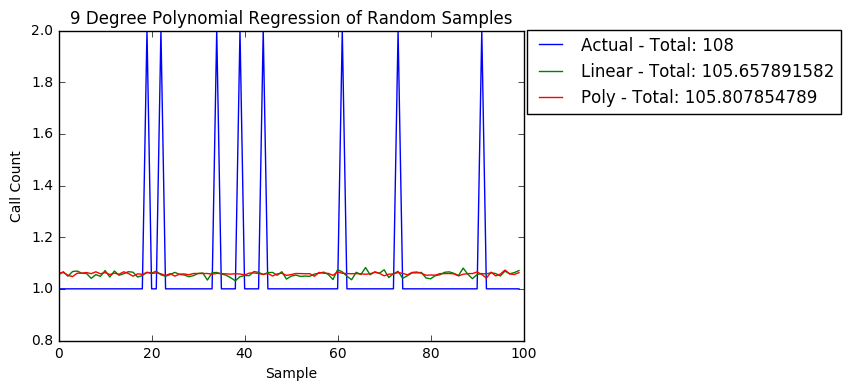

In [18]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef5
traintest2 = coef6
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("9 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [19]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 3)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 2.164065780860483


In [20]:
coef7 = getLinearFit(uniques, yValues)[0]
errors7 = getError(uniques, yValues, coef7)
print("Polynomial coefficients:")
print(coef7)
print("Max Error, Avg Error, RMS Error")
print(errors7[:3])

Polynomial coefficients:
[ -6.76468752e+00   2.40836781e-01   8.16150168e-03   3.81425453e-03
  -7.81565919e-03   1.17618930e-02  -9.08477561e-06  -6.99274490e-03
   7.08011423e-02]
Max Error, Avg Error, RMS Error
(10.506061448312948, 0.58007781176453865, 0.74446331823317113)


In [21]:
coef8 = getPolyFit(uniques, yValues)[0]
errors8 = getError(uniques, yValues, coef8, True)
print("Polynomial coefficients:")
print(coef8)
print("Max Error, Avg Error, RMS Error")
print(errors8[:3])

Polynomial coefficients:
[ -7.33528501e-14  -3.85540899e-08   1.08675998e-05   1.74783889e-10
  -1.72385860e-12   1.80852346e-08   1.85922682e-13  -2.02219382e-07
  -1.41653724e-05]
Max Error, Avg Error, RMS Error
(10.467505696074419, 0.58812859186912891, 0.74794051825517216)


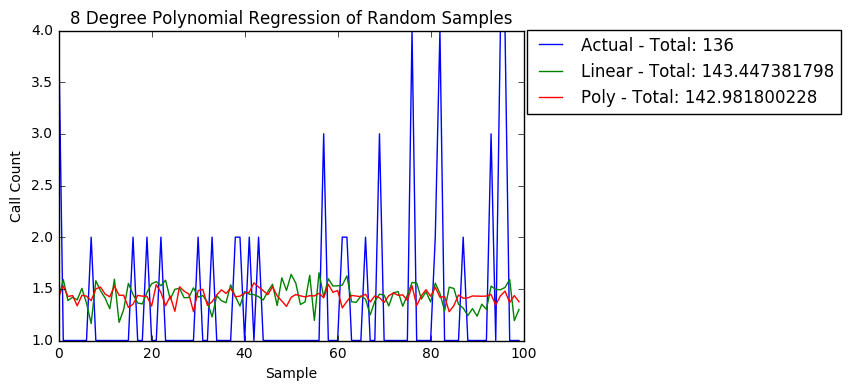

In [23]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef7
traintest2 = coef8
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("8 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [24]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 4)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 1.7084898269749829


In [25]:
coef9 = getLinearFit(uniques, yValues)[0]
errors9 = getError(uniques, yValues, coef9)
print("Polynomial coefficients:")
print(coef9)
print("Max Error, Avg Error, RMS Error")
print(errors9[:3])

Polynomial coefficients:
[ -1.59077862e+01   9.97144041e-01   3.31518742e-02   8.32280632e-03
  -3.26238429e-02   5.06789006e-02   8.77351971e-05  -2.18912611e-02]
Max Error, Avg Error, RMS Error
(11.638374047054585, 1.0997400681854981, 1.3893992864372884)


In [26]:
coef10 = getPolyFit(uniques, yValues)[0]
errors10 = getError(uniques, yValues, coef10, True)
print("Polynomial coefficients:")
print(coef10)
print("Max Error, Avg Error, RMS Error")
print(errors10[:3])

Polynomial coefficients:
[  1.26000648e-15   1.12509526e-07   2.86237018e-05   2.91190850e-10
  -6.43644866e-12   9.78521701e-08   6.11962204e-13  -7.66900126e-07]
Max Error, Avg Error, RMS Error
(11.569289952184233, 1.1428210522588764, 1.4195592406938062)


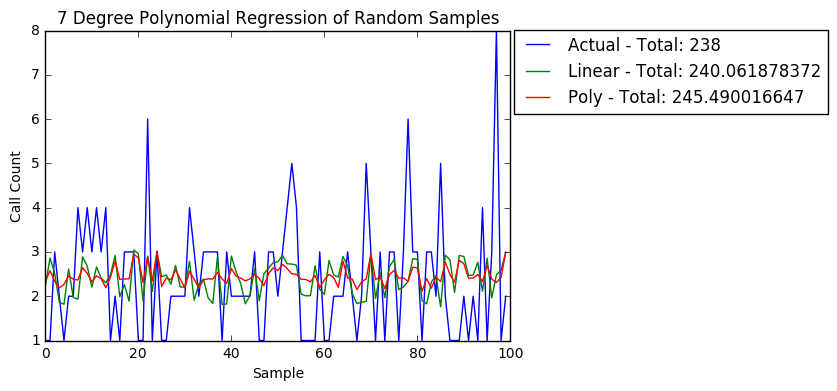

In [28]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef9
traintest2 = coef10
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("7 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [29]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 5)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 1.3951659514082166


In [30]:
coef11 = getLinearFit(uniques, yValues)[0]
errors11 = getError(uniques, yValues, coef11)
print("Polynomial coefficients:")
print(coef11)
print("Max Error, Avg Error, RMS Error")
print(errors11[:3])

Polynomial coefficients:
[ -1.48065129e+01   9.88813276e-01   3.28846815e-02   7.74709922e-03
  -3.23486797e-02   5.07654802e-02   8.75751995e-05]
Max Error, Avg Error, RMS Error
(11.682778807981213, 1.0999804954825481, 1.3900826484646118)


In [31]:
coef12 = getPolyFit(uniques, yValues)[0]
errors12 = getError(uniques, yValues, coef12, True)
print("Polynomial coefficients:")
print(coef12)
print("Max Error, Avg Error, RMS Error")
print(errors12[:3])

Polynomial coefficients:
[  1.13579856e-15   1.36953954e-07   2.80324994e-05   2.86188505e-10
  -6.44419854e-12   9.79540822e-08   6.08904744e-13]
Max Error, Avg Error, RMS Error
(11.610751597543425, 1.1456868360009689, 1.4214442245186296)


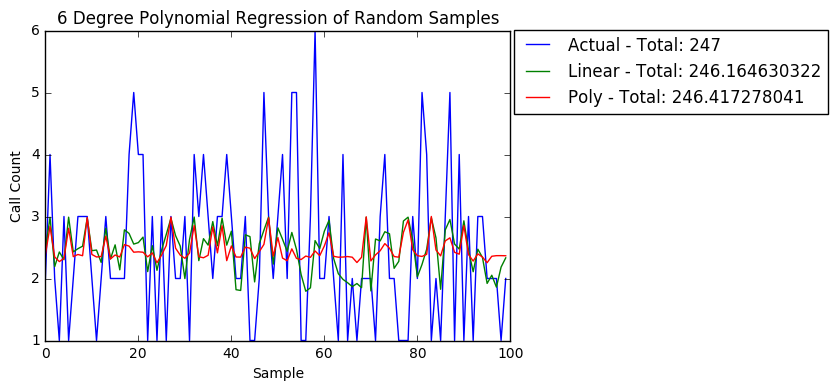

In [34]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef11
traintest2 = coef12
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("6 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [35]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 6)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 1.1077177982606372


In [36]:
coef13 = getLinearFit(uniques, yValues)[0]
errors13 = getError(uniques, yValues, coef13)
print("Polynomial coefficients:")
print(coef13)
print("Max Error, Avg Error, RMS Error")
print(errors13[:3])

Polynomial coefficients:
[ -3.75972179e+03   7.72407805e+01   2.55487089e+00   1.85795943e+00
  -2.52138319e+00   4.66166622e+00]
Max Error, Avg Error, RMS Error
(203.0902974769956, 32.106866590473985, 39.049694947468041)


In [37]:
coef14 = getPolyFit(uniques, yValues)[0]
errors14 = getError(uniques, yValues, coef14, True)
print("Polynomial coefficients:")
print(coef14)
print("Max Error, Avg Error, RMS Error")
print(errors14[:3])

Polynomial coefficients:
[ -5.48214372e-12  -1.50459882e-06   1.86689778e-03   1.31572485e-08
  -3.83671707e-10   1.04366097e-05]
Max Error, Avg Error, RMS Error
(193.01069457678491, 40.607671839341904, 47.152380068826403)


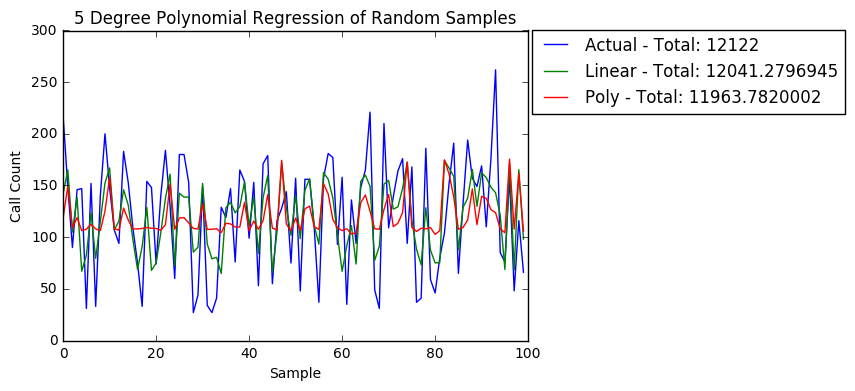

In [40]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef13
traintest2 = coef14
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("5 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [41]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 7)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 0.7004764043736031


In [42]:
coef15 = getLinearFit(uniques, yValues)[0]
errors15 = getError(uniques, yValues, coef15)
print("Polynomial coefficients:")
print(coef15)
print("Max Error, Avg Error, RMS Error")
print(errors15[:3])

Polynomial coefficients:
[ -9.19787498e+04   1.80360500e+03   5.99651429e+01   4.61190240e+01
  -5.89336865e+01]
Max Error, Avg Error, RMS Error
(1843.9012826282415, 210.34278403109309, 286.66246089063776)


In [43]:
coef16 = getPolyFit(uniques, yValues)[0]
errors16 = getError(uniques, yValues, coef16, True)
print("Polynomial coefficients:")
print(coef16)
print("Max Error, Avg Error, RMS Error")
print(errors16[:3])

Polynomial coefficients:
[  8.48436750e-11  -3.99070384e-05   4.99663373e-02   3.50599659e-07
  -1.06986096e-08]
Max Error, Avg Error, RMS Error
(1729.2422408761076, 210.70061630883603, 287.50746687757675)


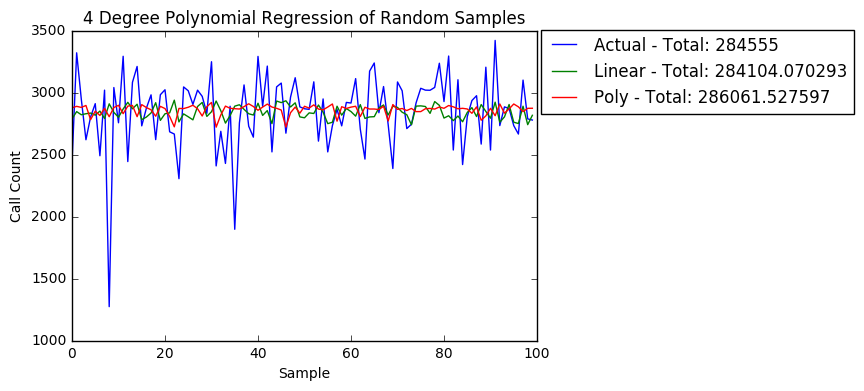

In [55]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef15
traintest2 = coef16
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("4 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [56]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 8)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 0.5259667840391558


In [57]:
coef17 = getLinearFit(uniques, yValues)[0]
errors17 = getError(uniques, yValues, coef17)
print("Polynomial coefficients:")
print(coef17)
print("Max Error, Avg Error, RMS Error")
print(errors17[:3])

Polynomial coefficients:
[  1.07612972e+05   6.79260447e+00   1.14605324e+00  -5.20079594e+01]
Max Error, Avg Error, RMS Error
(1852.1673972190765, 212.54893008497518, 288.73041941922276)


In [58]:
coef18 = getPolyFit(uniques, yValues)[0]
errors18 = getError(uniques, yValues, coef18, True)
print("Polynomial coefficients:")
print(coef18)
print("Max Error, Avg Error, RMS Error")
print(errors18[:3])

Polynomial coefficients:
[  7.97306183e-10  -1.74790135e-06   3.79797953e-02   3.46932394e-07]
Max Error, Avg Error, RMS Error
(1843.5539555232799, 215.25995014989402, 291.10080195885143)


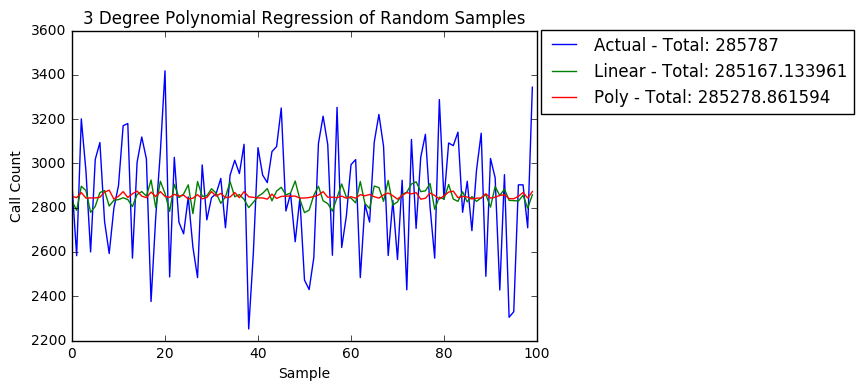

In [62]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef17
traintest2 = coef18
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("3 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [63]:
subset = []
subset = tuple(tuple(i[j] for j in range(len(i) - 9)) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 0.44772253109431404


In [64]:
coef19 = getLinearFit(uniques, yValues)[0]
errors19 = getError(uniques, yValues, coef19)
print("Polynomial coefficients:")
print(coef19)
print("Max Error, Avg Error, RMS Error")
print(errors19[:3])

Polynomial coefficients:
[  6.09305917e+03  -7.71440803e+01  -6.06973631e+00]
Max Error, Avg Error, RMS Error
(2988.7486576185584, 628.02011389126028, 851.55012894041988)


In [65]:
coef20 = getPolyFit(uniques, yValues)[0]
errors20 = getError(uniques, yValues, coef20, True)
print("Polynomial coefficients:")
print(coef20)
print("Max Error, Avg Error, RMS Error")
print(errors20[:3])

Polynomial coefficients:
[  6.04564017e+03  -7.71454987e+01  -1.47924207e-01]
Max Error, Avg Error, RMS Error
(2992.9449186934316, 628.30007701289935, 852.17409707841523)


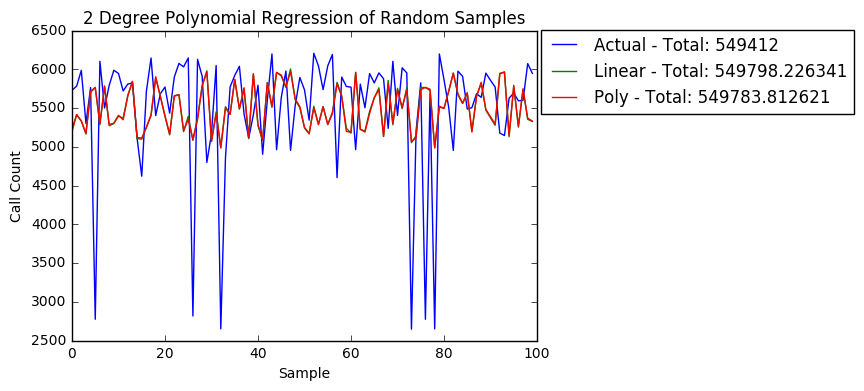

In [74]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef19
traintest2 = coef20
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("2 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [75]:
coefLin = [coef1, coef3, coef5, coef7, coef9, coef11, coef13, coef15, coef17, coef19]
coefPoly = [coef2, coef4, coef6, coef8, coef10, coef12, coef14, coef16, coef18, coef20]

print("<table><tr><td>N</td><td>Fit</td><td>intercept</td>")
for i in columnHeaders:
    print("<td>" + str(i) + "</td>")
print("</tr>")
for i in range(10):
    print("<tr><td>" + str(11 - i) + "</td><td>Linear</td>")
    for j in range(len(coefLin[i])):
        print("<td>" + str(coefLin[i][j]) + "</td>")
    for j in range(12 - len(coefLin[i])):
        print("<td>&nbsp;</td>")
    print("</tr>")
    print("<tr><td>" + str(11 - i) + "</td><td>Poly</td>")
    for j in range(len(coefPoly[i])):
        print("<td>" + str(coefPoly[i][j]) + "</td>")
    for j in range(12 - len(coefPoly[i])):
        print("<td>&nbsp;</td>")
    print("</tr>")
print("</table>")

<table><tr><td>N</td><td>Fit</td><td>intercept</td>
<td>month</td>
<td>day</td>
<td>year</td>
<td>dayOfYear</td>
<td>callHour</td>
<td>callMin</td>
<td>dayOfWeek</td>
<td>priority</td>
<td>district</td>
<td>longitude</td>
<td>latitude</td>
</tr>
<tr><td>11</td><td>Linear</td>
<td>3.00850324756</td>
<td>-0.0387358808147</td>
<td>-0.00124720547524</td>
<td>-0.000969099977483</td>
<td>0.0012670715472</td>
<td>8.47781326422e-05</td>
<td>4.72800018731e-06</td>
<td>-2.18945604005e-05</td>
<td>-0.000699778248826</td>
<td>-0.000162665134027</td>
<td>-0.00112645367109</td>
<td>-0.000513111591434</td>
</tr>
<tr><td>11</td><td>Poly</td>
<td>2.01924605246e-33</td>
<td>-1.52588020748e-28</td>
<td>8.87468518374e-31</td>
<td>1.65026041098e-23</td>
<td>2.1828175586e-23</td>
<td>1.97564166909e-27</td>
<td>1.91396501278e-23</td>
<td>1.17646227102e-28</td>
<td>8.94389244496e-29</td>
<td>-9.77261820515e-23</td>
<td>4.58795421745e-17</td>
<td>-1.13409258975e-21</td>
</tr>
<tr><td>10</td><td>Linear</td>
<td

In [76]:

errorLin = [errors1, errors3, errors5, errors7, errors9, errors11, errors13, errors15, errors17, errors19]
errorPoly = [errors2, errors4, errors6, errors8, errors10, errors12, errors14, errors16, errors18, errors20 ]
print("<table><tr><td>N</td><td>Fit</td><td>Max Error</td><td>Avg Error</td><td>RMS Error</td></tr>")
for i in range(10):
    print("<tr><td>" + str(11 - i) + "</td><td>Linear</td>")
    for j in range(len(errorLin[i])):
        print("<td>" + str(errorLin[i][j]) + "</td>")
    print("</tr>")
    print("<tr><td>" + str(11 - i) + "</td><td>Poly</td>")
    for j in range(len(errorPoly[i])):
        print("<td>" + str(errorPoly[i][j]) + "</td>")
    print("</tr>")
print("</table>")

<table><tr><td>N</td><td>Fit</td><td>Max Error</td><td>Avg Error</td><td>RMS Error</td></tr>
<tr><td>11</td><td>Linear</td>
<td>9.98974474941</td>
<td>0.0203437750255</td>
<td>0.108060508765</td>
</tr>
<tr><td>11</td><td>Poly</td>
<td>9.99216561552</td>
<td>0.0565744779775</td>
<td>0.222912723629</td>
</tr>
<tr><td>10</td><td>Linear</td>
<td>9.98728810972</td>
<td>0.0241185709863</td>
<td>0.11795977694</td>
</tr>
<tr><td>10</td><td>Poly</td>
<td>9.9884294499</td>
<td>0.0241218613361</td>
<td>0.117968919819</td>
</tr>
<tr><td>9</td><td>Linear</td>
<td>9.93514927207</td>
<td>0.109779687659</td>
<td>0.252733940289</td>
</tr>
<tr><td>9</td><td>Poly</td>
<td>9.93084263204</td>
<td>0.110106404715</td>
<td>0.252823063523</td>
</tr>
<tr><td>8</td><td>Linear</td>
<td>10.5060614483</td>
<td>0.580077811765</td>
<td>0.744463318233</td>
</tr>
<tr><td>8</td><td>Poly</td>
<td>10.4675056961</td>
<td>0.588128591869</td>
<td>0.747940518255</td>
</tr>
<tr><td>7</td><td>Linear</td>
<td>11.6383740471</td>


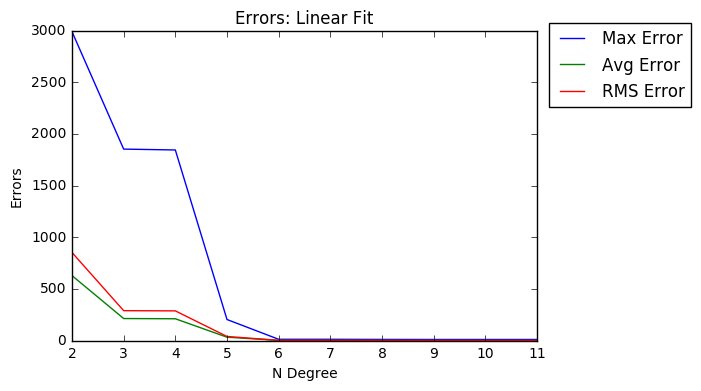

In [77]:
xx = []
yy1 = []
yy2 = []
yy3 = []
typeOfError = ["Max Error", "Avg Error", "RMS Error"]

errorLin = [errors1, errors3, errors5, errors7, errors9, errors11, errors13, errors15, errors17, errors19]
errorPoly = [errors2, errors4, errors6, errors8, errors10, errors12, errors14, errors16, errors18, errors20 ]

for i in range(10):
    xx.append(len(coefLin[i]) - 1)
    yy1.append(errorLin[i][0])
    yy2.append(errorLin[i][1])
    yy3.append(errorLin[i][2])

plt.title("Errors: Linear Fit")
plt.plot(xx, yy1, label="Max Error")
plt.plot(xx, yy2, label="Avg Error")
plt.plot(xx, yy3, label="RMS Error")
plt.xlabel("N Degree")
plt.ylabel("Errors")
plt.legend(bbox_to_anchor=(1.35, 1.05))



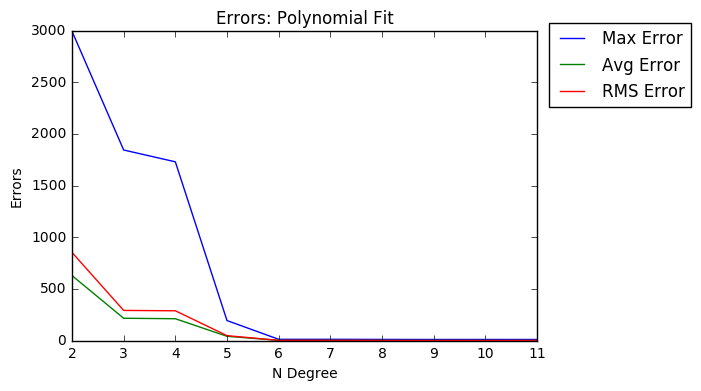

In [96]:
xx = []
yy1 = []
yy2 = []
yy3 = []
typeOfError = ["Max Error", "Avg Error", "RMS Error"]
for i in range(10):
    xx.append(len(coefPoly[i]) - 1)
    yy1.append(errorPoly[i][0])
    yy2.append(errorPoly[i][1])
    yy3.append(errorPoly[i][2])

plt.title("Errors: Polynomial Fit")
plt.plot(xx, yy1, label="Max Error")
plt.plot(xx, yy2, label="Avg Error")
plt.plot(xx, yy3, label="RMS Error")
plt.xlabel("N Degree")
plt.ylabel("Errors")
plt.legend(bbox_to_anchor=(1.35, 1.05))



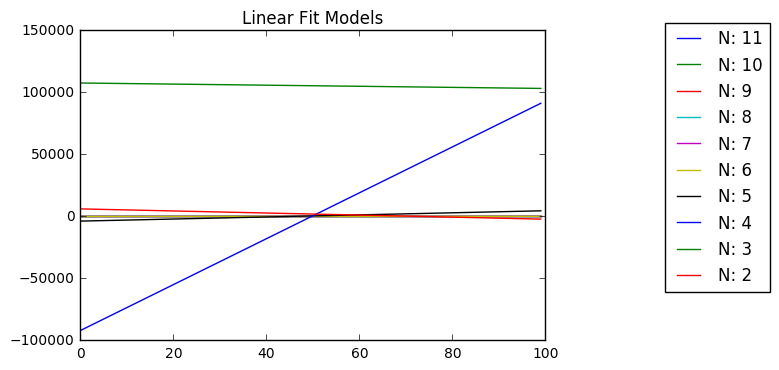

In [78]:
# plot them together
xx = [ float(i) for i in range (100)]
#coefLin = [coef1, coef3, coef5, coef7, coef9, coef11, coef13, coef15, coef17, coef19]
#coefPoly = [coef2, coef4, coef6, coef8, coef10, coef12, coef14, coef16, coef18, coef20]
for i in range(10):
    yy = [ sum([ j * coefLin[i][k+1] for k in range(len(coefLin[i]) - 1) ])+coefLin[i][0] for j in xx]
    plt.plot(xx, yy , label="N: " + str(len(coefLin[i]) - 1) )
plt.title("Linear Fit Models")
plt.legend(bbox_to_anchor=(1.5, 1.05))

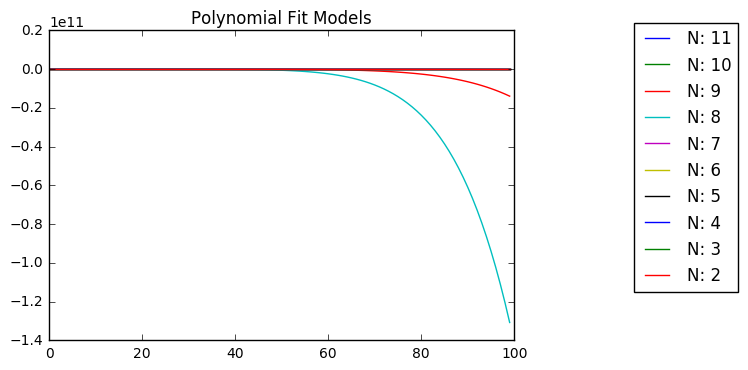

In [79]:
# plot them together
xx = [ float(i) for i in range (100)]
#coefLin = [coef1, coef3, coef5, coef7, coef9, coef11, coef13, coef15, coef17, coef19]
#coefPoly = [coef2, coef4, coef6, coef8, coef10, coef12, coef14, coef16, coef18, coef20]
for i in range(10):
    yy = [ sum([ (j**k) * coefPoly[i][k] for k in range(len(coefPoly[i])) ]) for j in xx]
    plt.plot(xx, yy , label="N: " + str(len(coefPoly[i]) - 1) )
plt.title("Polynomial Fit Models")
plt.legend(bbox_to_anchor=(1.5, 1.05))

In [80]:
columnHeaders

['month',
 'day',
 'year',
 'dayOfYear',
 'callHour',
 'callMin',
 'dayOfWeek',
 'priority',
 'district',
 'longitude',
 'latitude']

In [129]:
# best curve model
subset = []
subset = tuple(tuple([ i[0], i[1], i[2], i[3], i[4], i[6], i[7], i[8] ]) for i in df)
print("Aggregating y value (call volume) based on user criteria")
time3 = time.clock()
c = Counter(subset)
yValues = []
uniques = []
for i, j in c.items():
    uniques.append(i)
    yValues.append(j)
time4 = time.clock()
print("Time it took to generate y dataset: " + str(time4 - time3))

Aggregating y value (call volume) based on user criteria
Time it took to generate y dataset: 1.5655700951283507


In [82]:
coef21 = getLinearFit(uniques, yValues)[0]
errors21 = getError(uniques, yValues, coef21)
print("Polynomial coefficients:")
print(coef21)
print("Max Error, Avg Error, RMS Error")
print(errors21[:3])

Polynomial coefficients:
[  3.69770853e+02  -2.09542517e+00  -6.64502345e-02  -1.81160489e-01
   6.87759759e-02   9.59403723e-02  -2.08642278e-02   2.16131293e-01
  -2.57261461e-02]
Max Error, Avg Error, RMS Error
(79.38969033063205, 2.4395960303647786, 3.3057923300021543)


In [83]:
coef22 = getPolyFit(uniques, yValues)[0]
errors22 = getError(uniques, yValues, coef22, True)
print("Polynomial coefficients:")
print(coef22)
print("Max Error, Avg Error, RMS Error")
print(errors22[:3])

Polynomial coefficients:
[ -1.27183683e-11  -5.02713769e-08   5.80578331e-05   4.89230020e-10
  -1.76917532e-11   1.96852196e-07  -6.00122762e-06  -4.35322760e-04
  -1.43680826e-09]
Max Error, Avg Error, RMS Error
(79.932294939799419, 2.4263247388647846, 3.3037575769690117)


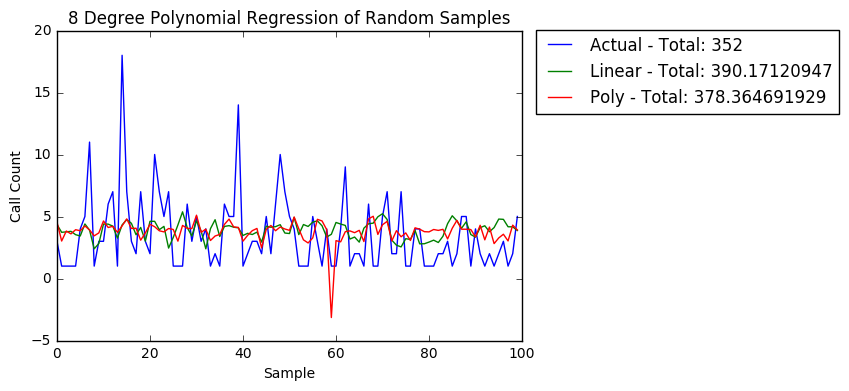

In [87]:
arrDates = []
for i in range(randomSampleSize):
    arrDates.append(uniques[ random.randint(0, len(uniques))])
actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
traintest1 = coef21
traintest2 = coef22
callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
xxx = [i for i in range(len(arrDates)) ]
plt.title("8 Degree Polynomial Regression of Random Samples")
plt.plot(xxx, actualCalls, label="Actual - Total: " + str(sum(actualCalls)))
plt.plot(xxx, callLin, label="Linear - Total: " + str(sum(callLin)))
plt.plot(xxx, callPoly, label="Poly - Total: " + str(sum(callPoly)))
plt.xlabel("Sample")
plt.ylabel("Call Count")
plt.legend(bbox_to_anchor=(1.7, 1.03))

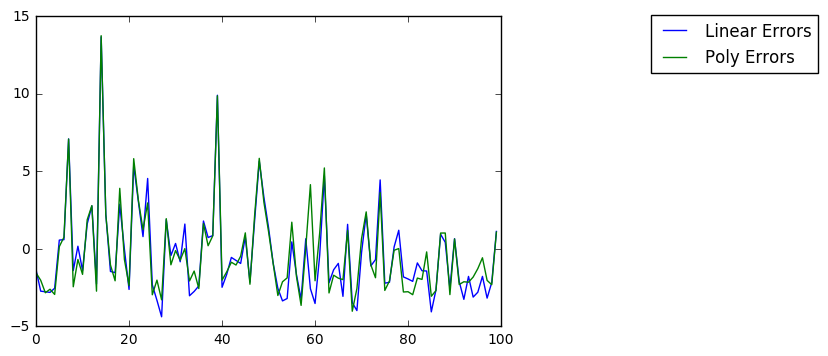

In [93]:
error1 = [(actualCalls[i] - callLin[i]) for i in range(len(actualCalls)) ]
error2 = [(actualCalls[i] - callPoly[i]) for i in range(len(actualCalls)) ]
plt.plot(xxx, error1, label="Linear Errors")
plt.plot(xxx, error2, label="Poly Errors")
plt.legend(bbox_to_anchor=(1.7, 1.03))

In [130]:
traintest1 = coef21
traintest2 = coef22
avgCall, varianceCall = [[],[]], [[],[]]
size=1000
for m in range(size):
    arrDates = []
    for i in range(m + 1):
        arrDates.append(uniques[ random.randint(0, len(uniques))])
    actualCalls  = [ yValues[ uniques.index(i) ] for i in arrDates ]
    callLin = [ sum ( i[j]*traintest1[j+1] for j in range(len(i)) ) + traintest1[0]  for i in arrDates ]
    callPoly = [ sum ( (i[j]**(j+1))*traintest2[j+1] for j in range(len(i)) ) + traintest2[0]  for i in arrDates ]
    avgCall[0].append(sum(callLin)/(m+1))
    avgCall[1].append(sum(callPoly)/(m+1))
    varianceCall[0].append(sum([ (n - avgCall[0][m])**2 for n in callLin]) / (m+1))
    varianceCall[1].append(sum([ (n - avgCall[1][m])**2 for n in callPoly]) / (m+1))

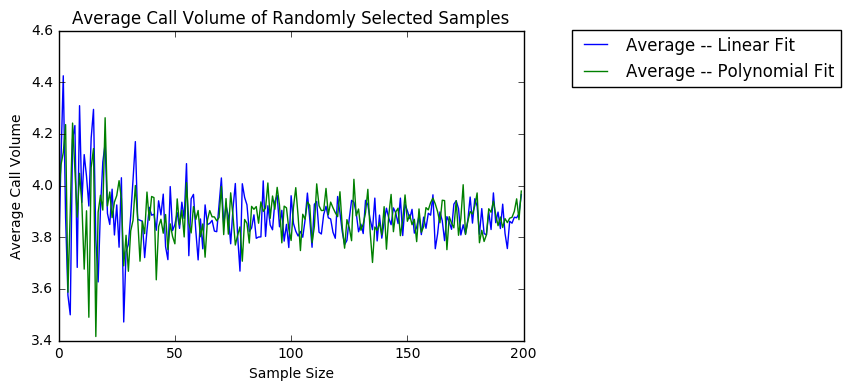

In [132]:
plt.plot([i for i in range(size)], avgCall[0], label="Average -- Linear Fit")
plt.plot([i for i in range(size)], avgCall[1], label="Average -- Polynomial Fit")
plt.xlabel("Sample Size")
plt.ylabel("Average Call Volume")
plt.title("Average Call Volume of Randomly Selected Samples")
plt.legend(bbox_to_anchor=(1.7, 1.03))

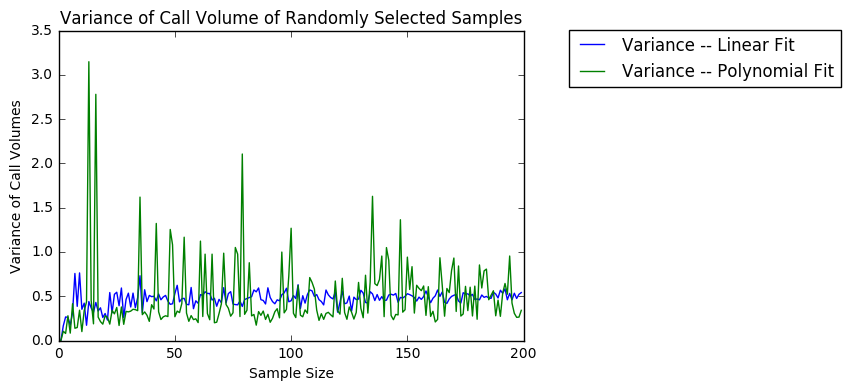

In [133]:
plt.plot([i for i in range(size)], varianceCall[0], label="Variance -- Linear Fit")
plt.plot([i for i in range(size)], varianceCall[1], label="Variance -- Polynomial Fit")
plt.xlabel("Sample Size")
plt.ylabel("Variance of Call Volumes")
plt.title("Variance of Call Volume of Randomly Selected Samples")
plt.legend(bbox_to_anchor=(1.7, 1.03))

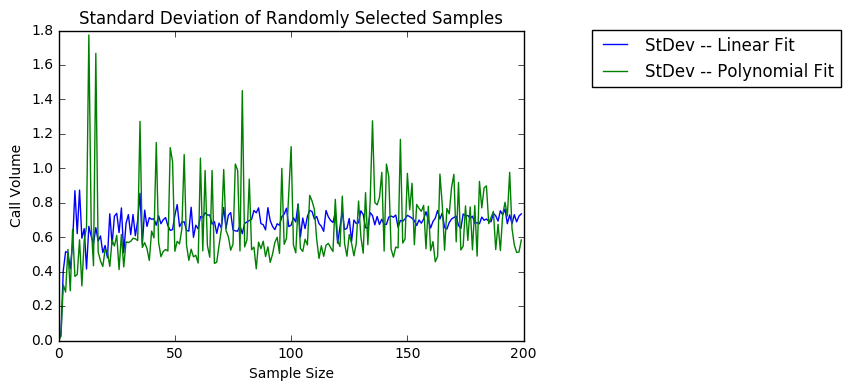

In [134]:
plt.plot([i for i in range(size)], [i**(1/2) for i in varianceCall[0] ], label="StDev -- Linear Fit")
plt.plot([i for i in range(size)], [i**(1/2) for i in varianceCall[1] ], label="StDev -- Polynomial Fit")
plt.xlabel("Sample Size")
plt.ylabel("Call Volume")
plt.title("Standard Deviation of Randomly Selected Samples")
plt.legend(bbox_to_anchor=(1.7, 1.03))